In [1]:
from fast_cleaning import fast_cleaning_longer, fast_cleaning_merge
from cleaning_old_longer import cleaning_old_longer
from cleaning_old_merge import cleaning_old_merge
from validation import get_efficiency, get_fake_rate
from coating_cleaning import coating_cleaning
from matplotlib import pyplot as plt
from get_data import *
from time import time
import pandas as pd
import matplotlib
import os


Create variables for analyse

In [8]:
path = "data/selecting_pri_and_sec"
event_list = os.listdir(path)
cleaning_type_list = ["cleaning_old_longer",
                      "cleaning_old_merge",
                      "fast_cleaning_longer",
                      "fast_cleaning_merge",
                      "coating_cleaning"]

cleaning_func_list = [cleaning_old_longer,
                      cleaning_old_merge,
                      fast_cleaning_longer,
                      fast_cleaning_merge,
                      coating_cleaning]
plot_title = ["Efficiency",
              "Cleaning efficiency/Raw efficiency", 
              "Number of tracks left",
              "Time",
              "Fake rate",
              "Duplicates"]

Create data objects for store information

In [3]:
event_list = [event_list[i:i + 2] for i in range(0, len(event_list), 2)]
df_efficiency = pd.DataFrame(columns=cleaning_type_list.append("raw"))
df_time = pd.DataFrame(columns=cleaning_type_list)
df_fake_rate = pd.DataFrame(columns=cleaning_type_list)
df_tracks_number = pd.DataFrame(columns=cleaning_type_list)
df_duplicate = pd.DataFrame(columns=cleaning_type_list)

Collect statistics of all types of cleaning

In [4]:
from validation import get_duplication_rate

for event_number, event in enumerate(event_list):
    hit_file = event[0]
    track_file = event[1]

    tracks = get_tracks_data(f'{path}/{track_file}')
    hits = get_hits_data_for_validation(f'{path}/{hit_file}')
    
    print(f"###############################{event_number}/{len(event_list)}###############################")
    if not len(tracks) or not len(hits):
        print("ZERO")
        continue

    for cleaning_type, cleaning_func in zip(cleaning_type_list, cleaning_func_list):
        s = time()
        cleaned_tracks = cleaning_func(list(map(lambda x: x.copy(), tracks)))
        df_time.at[event_number, cleaning_type] = time() - s
        df_efficiency.at[event_number, "raw"] = get_efficiency(tracks, hits, min_length=9)
        df_efficiency.at[event_number, cleaning_type] = get_efficiency(cleaned_tracks, hits, min_length=9)
        df_fake_rate.at[event_number, cleaning_type] = get_fake_rate(cleaned_tracks, hits)
        df_tracks_number.at[event_number, cleaning_type] = len(cleaned_tracks)
        df_duplicate.at[event_number, cleaning_type] = get_duplication_rate(cleaned_tracks, hits)

###############################0/100###############################
Before cleaning there are 9308 tracks
Starting the first stage of merging duplicates
The first stage of merging completed in 2.2622761726379395 seconds
Starting the second stage of merging duplicates
The second stage of merging completed in 2.839728832244873 seconds
Starting separate tracks
Track separating completed in 1.2649242877960205 seconds
Staring sorting the points in the track
Sorting completed in 0.3875467777252197 seconds
After cleaning there are 451 tracks
Number of reco tracks: 235
Number of real selected tracks: 303
Number of reco tracks: 231
Number of real selected tracks: 303
Number of fake tracks: 0
Number of real selected tracks: 209
Number of real reco tracks: 35
Number of reco tracks: 451
Before cleaning there are 9308 tracks
Starting the first stage of merging duplicates
The first stage of merging completed in 2.025813579559326 seconds
Starting the second stage of merging duplicates
The second stag

Create df with normalization for the best presentation

In [5]:
df_normalized_efficiency = df_efficiency[df_efficiency["raw"] != 0]
df_normalized_efficiency = df_normalized_efficiency.div(df_normalized_efficiency["raw"], axis=0)

Drawing

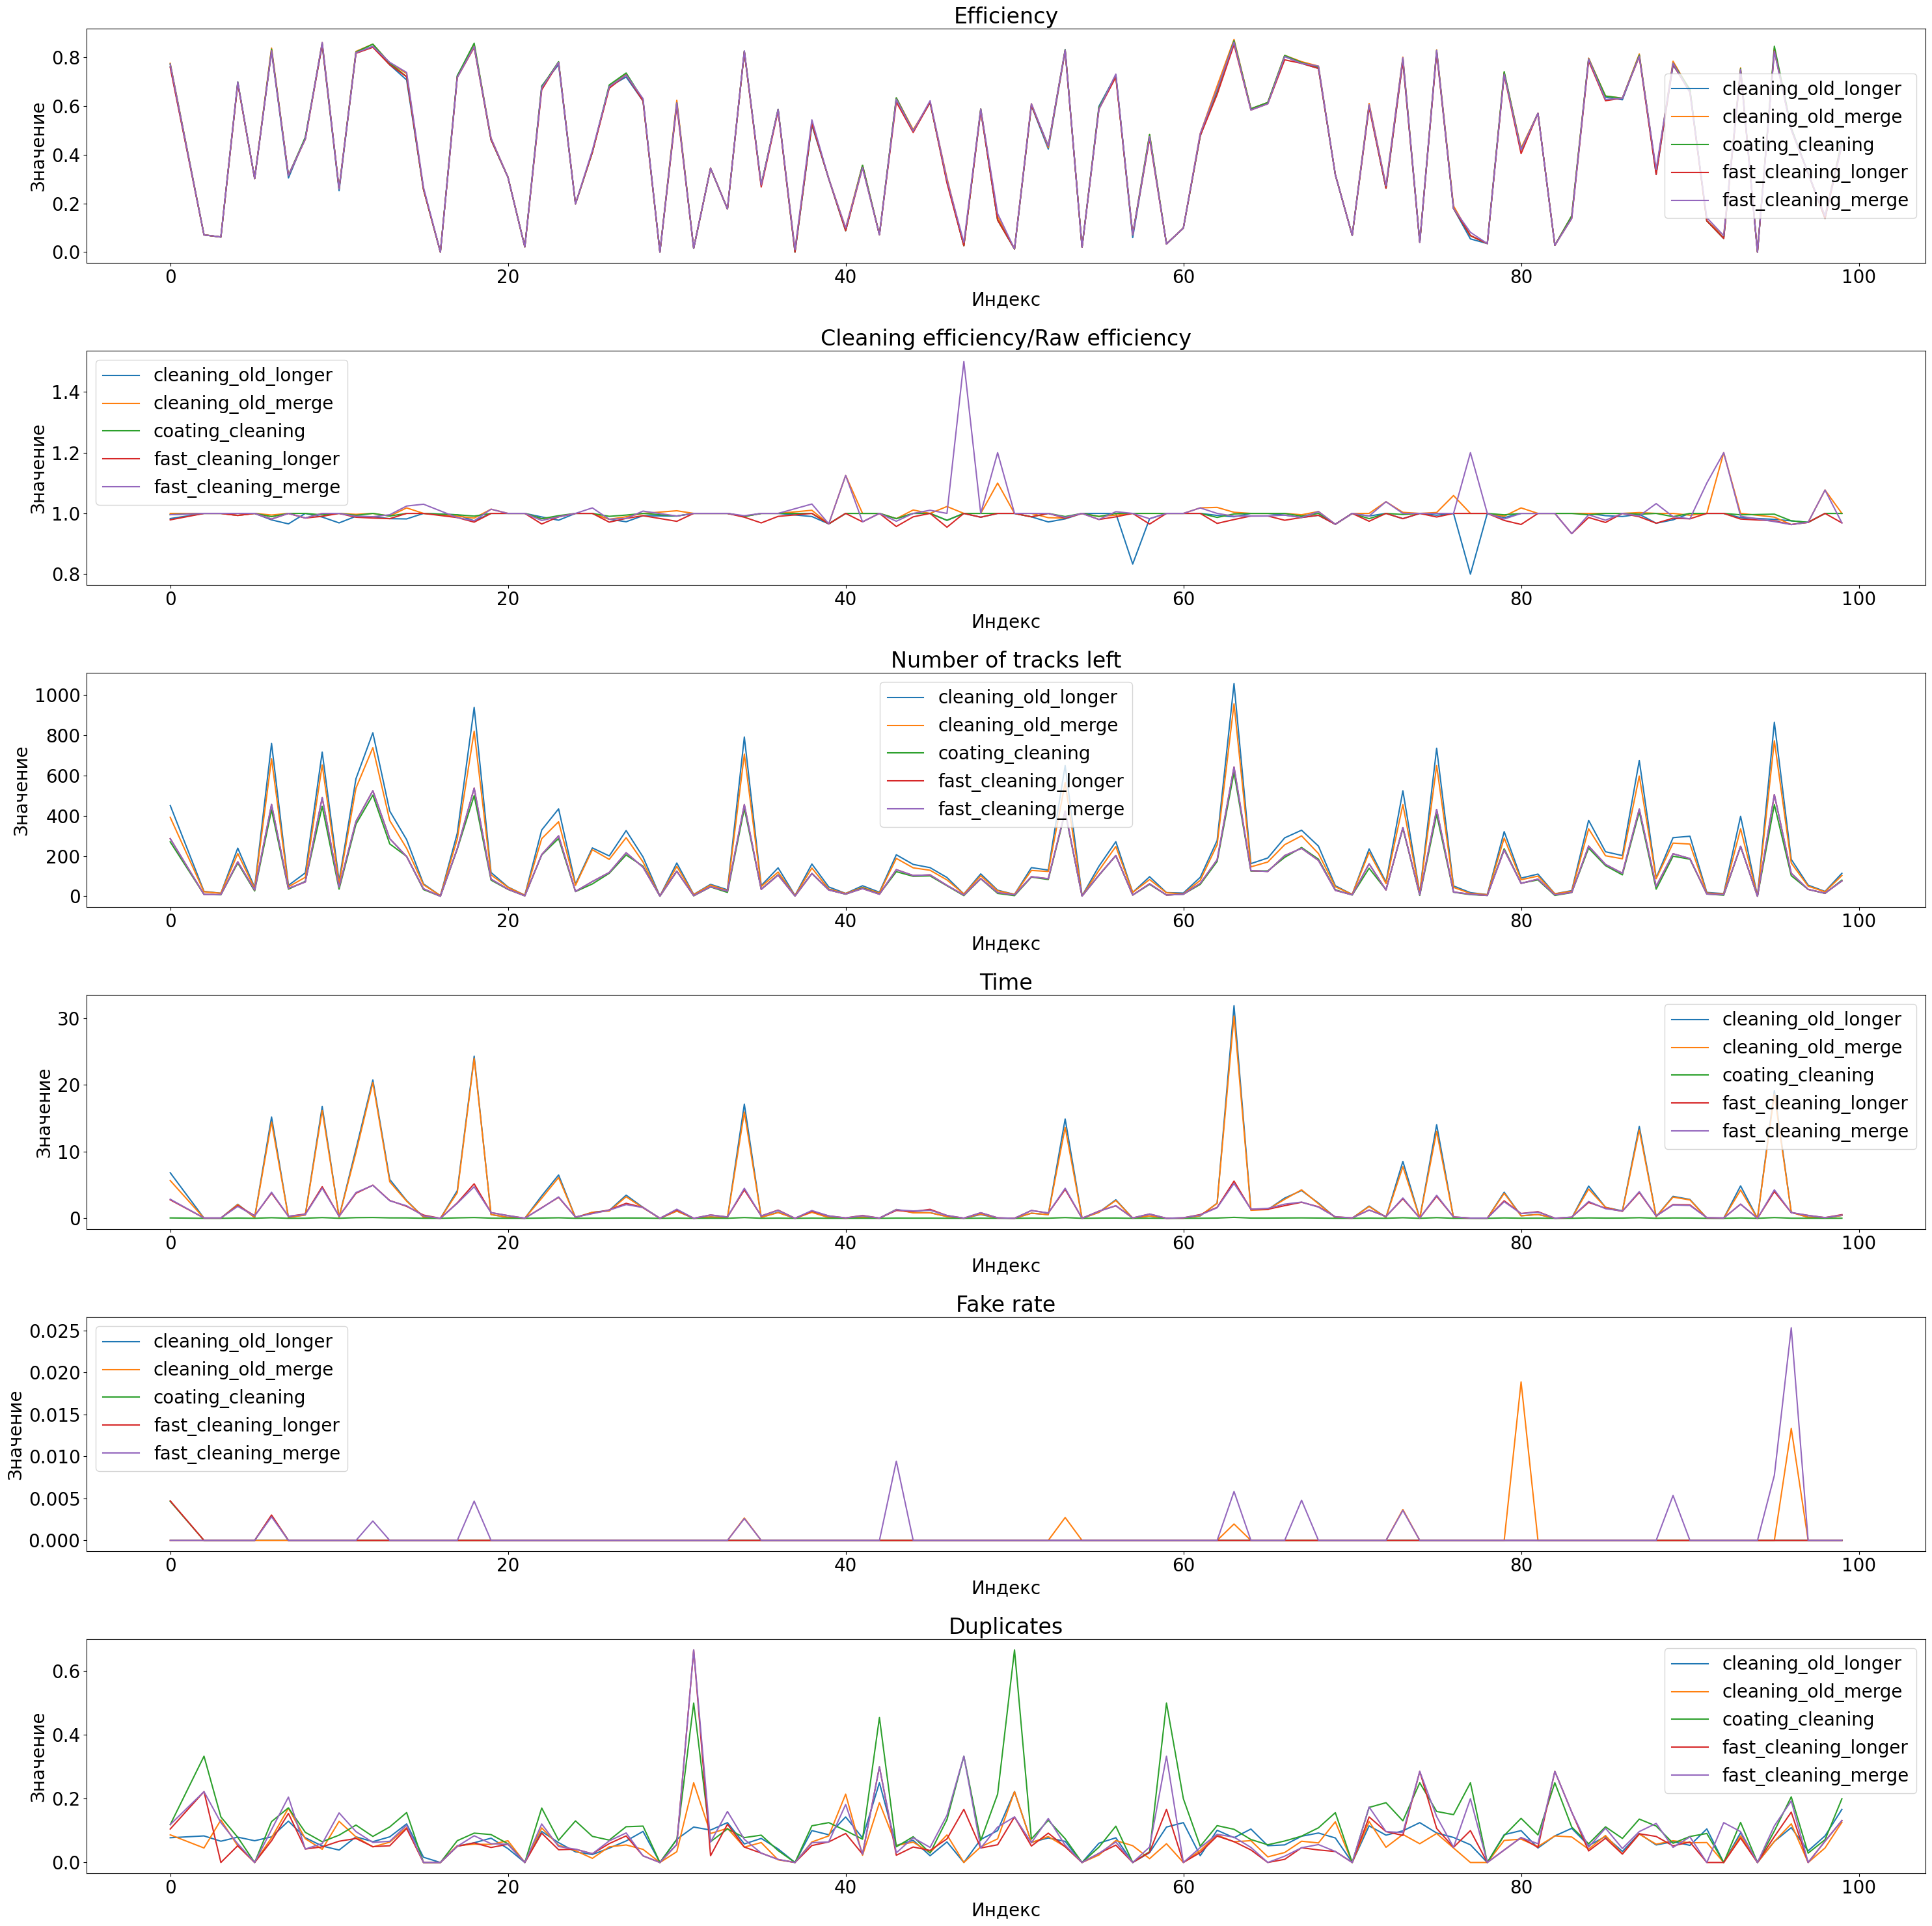

In [10]:
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(6, 1, figsize=(30, 30))

for i, df in enumerate([df_efficiency,
                        df_normalized_efficiency,
                        df_tracks_number,
                        df_time,
                        df_fake_rate,
                        df_duplicate]):
    for column in df.columns.difference(["raw"]):
        axs[i].plot(df.index, df[column], label=column)
    axs[i].set_xlabel("Индекс")
    axs[i].set_ylabel("Значение")
    axs[i].set_title(plot_title[i])
    axs[i].legend()

plt.tight_layout()
plt.show()